In [1]:
import sqlite3
import numpy as np
import pandas as pd

In [2]:
query = """
    SELECT * FROM sensor_table
    """
with sqlite3.connect('../datasets/dallas.sqlite') as db:
    sensors = pd.read_sql(query, db)

In [3]:
sensors.columns

Index(['sensor_index', 'name', 'latitude', 'longitude'], dtype='object')

In [4]:
query = """
    SELECT * FROM data_table
    """
with sqlite3.connect('../datasets/dallas.sqlite') as db:
    data = pd.read_sql(query, db)

In [5]:
data

,time_stamp,sensor_index,humidity_a,humidity_b,temperature_a,temperature_b,pressure_a,pressure_b,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1_a,pm2.5_cf_1_b
0,2024-03-31T00:00:00Z,2644,61.762,NaN,78.568,NaN,989.307,NaN,9.051,9.763,9.051,9.949
1,2024-03-30T00:00:00Z,2644,53.012,NaN,77.025,NaN,991.739,NaN,2.920,3.099,2.920,3.099
2,2024-03-29T00:00:00Z,2644,51.843,NaN,72.680,NaN,995.137,NaN,4.294,4.859,4.294,4.993
3,2024-03-28T00:00:00Z,2644,46.133,NaN,64.470,NaN,1000.703,NaN,6.048,6.485,6.048,6.485
4,2024-03-27T00:00:00Z,2644,42.156,NaN,60.199,NaN,996.619,NaN,3.537,4.024,3.537,4.024
...,...,...,...,...,...,...,...,...,...,...,...,...
43486,2023-10-22T00:00:00Z,196421,33.152,33.152,85.249,85.249,989.905,989.905,8.332,8.130,8.332,8.130
43487,2023-10-20T00:00:00Z,196421,24.275,24.275,83.393,83.393,990.390,990.390,3.788,3.622,3.788,3.622
43488,2023-10-19T00:00:00Z,196421,31.012,31.012,80.329,80.329,991.847,991.847,4.339,4.135,4.339,4.135
43489,2023-10-17T00:00:00Z,196421,17.511,17.511,85.463,85.463,994.537,994.537,3.602,4.069,3.602,4.069


In [6]:
data.columns

Index(['time_stamp', 'sensor_index', 'humidity_a', 'humidity_b',
       'temperature_a', 'temperature_b', 'pressure_a', 'pressure_b',
       'pm2.5_atm_a', 'pm2.5_atm_b', 'pm2.5_cf_1_a', 'pm2.5_cf_1_b'],
      dtype='object')

In [7]:
query = """
SELECT 
    s.sensor_index, 
    s.name, 
    s.latitude, 
    s.longitude, 
    d.time_stamp,
    d.humidity_a, 
    d.temperature_a, 
    d.pressure_a, 
    d."pm2.5_atm_a", 
    d."pm2.5_atm_b", 
    d."pm2.5_cf_1_a", 
    d."pm2.5_cf_1_b"
FROM 
    sensor_table AS s
JOIN 
    data_table AS d
ON 
    s.sensor_index = d.sensor_index
WHERE 
    d.time_stamp = '2024-03-30T00:00:00Z'
    
"""

with sqlite3.connect('../datasets/dallas.sqlite') as db:
    data_march_30 = pd.read_sql(query, db)
    
data_march_30

,sensor_index,name,latitude,longitude,time_stamp,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1_a,pm2.5_cf_1_b
0,2644,Sachse Farms,32.990840,-96.599300,2024-03-30T00:00:00Z,53.012,77.025,991.739,2.920,3.099,2.920,3.099
1,12969,Meadow Glen,32.991665,-96.859150,2024-03-30T00:00:00Z,68.232,79.918,989.738,3.176,3.941,3.176,3.941
2,13013,GPTX,32.766370,-97.037926,2024-03-30T00:00:00Z,47.996,78.404,995.925,3.663,3.460,3.663,3.460
3,16271,Arbormont Estates,32.882004,-97.084130,2024-03-30T00:00:00Z,53.761,77.072,990.509,3.462,2.452,3.465,2.452
4,46221,Thornbridge East,32.893590,-97.190370,2024-03-30T00:00:00Z,50.252,75.441,989.196,2.461,2.859,2.461,2.859
...,...,...,...,...,...,...,...,...,...,...,...,...
59,165171,Lake Arlington,32.678830,-97.221070,2024-03-30T00:00:00Z,50.415,77.792,991.652,2.720,2.584,2.720,2.584
60,182041,CleanAIRE NC Hickory Creek,33.126100,-97.059390,2024-03-30T00:00:00Z,42.982,79.114,991.808,3.418,3.827,3.418,3.827
61,184053,Creekwood Estates,32.909042,-97.124160,2024-03-30T00:00:00Z,46.140,81.353,992.833,3.481,3.660,3.481,3.660
62,196323,Duck Creek Air Quality,32.960114,-96.692200,2024-03-30T00:00:00Z,47.316,77.324,992.139,4.057,4.269,4.176,4.388


In [8]:
data_march_30.columns

Index(['sensor_index', 'name', 'latitude', 'longitude', 'time_stamp',
       'humidity_a', 'temperature_a', 'pressure_a', 'pm2.5_atm_a',
       'pm2.5_atm_b', 'pm2.5_cf_1_a', 'pm2.5_cf_1_b'],
      dtype='object')

In [9]:
data_march_30.set_index('sensor_index')

,name,latitude,longitude,time_stamp,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1_a,pm2.5_cf_1_b
sensor_index,,,,,,,,,,,
2644,Sachse Farms,32.990840,-96.599300,2024-03-30T00:00:00Z,53.012,77.025,991.739,2.920,3.099,2.920,3.099
12969,Meadow Glen,32.991665,-96.859150,2024-03-30T00:00:00Z,68.232,79.918,989.738,3.176,3.941,3.176,3.941
13013,GPTX,32.766370,-97.037926,2024-03-30T00:00:00Z,47.996,78.404,995.925,3.663,3.460,3.663,3.460
16271,Arbormont Estates,32.882004,-97.084130,2024-03-30T00:00:00Z,53.761,77.072,990.509,3.462,2.452,3.465,2.452
46221,Thornbridge East,32.893590,-97.190370,2024-03-30T00:00:00Z,50.252,75.441,989.196,2.461,2.859,2.461,2.859
...,...,...,...,...,...,...,...,...,...,...,...
165171,Lake Arlington,32.678830,-97.221070,2024-03-30T00:00:00Z,50.415,77.792,991.652,2.720,2.584,2.720,2.584
182041,CleanAIRE NC Hickory Creek,33.126100,-97.059390,2024-03-30T00:00:00Z,42.982,79.114,991.808,3.418,3.827,3.418,3.827
184053,Creekwood Estates,32.909042,-97.124160,2024-03-30T00:00:00Z,46.140,81.353,992.833,3.481,3.660,3.481,3.660


In [10]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
coordinates = np.column_stack((data_march_30['latitude'], data_march_30['longitude']))

nn_model = NearestNeighbors(n_neighbors=5+1, algorithm='kd_tree')
nn_model.fit(coordinates)

distances, neighbors = nn_model.kneighbors(coordinates)
neighbors = neighbors[:, 1:]


In [11]:
data_march_30= data_march_30.set_index('sensor_index')

In [12]:
data_march_30.index[neighbors[0]].to_list()

[87721, 196323, 144032, 196421, 147038]

In [13]:
data_march_30['nearest_neighbors'] = [data_march_30.index[neighbors[i]].to_list() for i in range(len(data_march_30))]

In [14]:
data_march_30.head()

,name,latitude,longitude,time_stamp,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1_a,pm2.5_cf_1_b,nearest_neighbors
sensor_index,,,,,,,,,,,,
2644,Sachse Farms,32.990840,-96.599300,2024-03-30T00:00:00Z,53.012,77.025,991.739,2.920,3.099,2.920,3.099,"[87721, 196323, 144032, 196421, 147038]"
12969,Meadow Glen,32.991665,-96.859150,2024-03-30T00:00:00Z,68.232,79.918,989.738,3.176,3.941,3.176,3.941,"[113833, 147038, 113642, 59953, 196421]"
13013,GPTX,32.766370,-97.037926,2024-03-30T00:00:00Z,47.996,78.404,995.925,3.663,3.460,3.663,3.460,"[135002, 16271, 184053, 99595, 109566]"
16271,Arbormont Estates,32.882004,-97.084130,2024-03-30T00:00:00Z,53.761,77.072,990.509,3.462,2.452,3.465,2.452,"[184053, 135002, 46221, 13013, 127049]"
46221,Thornbridge East,32.893590,-97.190370,2024-03-30T00:00:00Z,50.252,75.441,989.196,2.461,2.859,2.461,2.859,"[51821, 184053, 16271, 99585, 127045]"


In [15]:
distances = distances[:,1:]

In [16]:
weights = 1/distances

In [17]:
weights.shape

(64, 5)

In [18]:
weights_dict = {}
for i, sensor_idx in enumerate(data_march_30.index):
    neighbor_indices = data_march_30.index[neighbors[i]]
    weights_dict[sensor_idx] = pd.Series(weights[i], index=neighbor_indices)

In [19]:
weights_dict

{2644: sensor_index
 87721     22.493422
 196323    10.219791
 144032     6.390445
 196421     5.639625
 147038     4.770331
 dtype: float64,
 12969: sensor_index
 113833    19.729089
 147038    18.592297
 113642    18.279316
 59953     12.753930
 196421    11.869590
 dtype: float64,
 13013: sensor_index
 135002    13.649043
 16271      8.030631
 184053     5.998508
 99595      5.828402
 109566     5.209995
 dtype: float64,
 16271: sensor_index
 184053    20.701430
 135002    10.042084
 46221      9.357173
 13013      8.030631
 127049     7.062703
 dtype: float64,
 46221: sensor_index
 51821     15.351762
 184053    14.708223
 16271      9.357173
 99585      8.429501
 127045     7.515522
 dtype: float64,
 51821: sensor_index
 46221     15.351762
 99585     12.455497
 151486     7.676567
 184053     7.558998
 127045     6.299892
 dtype: float64,
 53365: sensor_index
 164965    21.876136
 113642    21.377596
 53389     18.025823
 120681    12.070896
 113833    11.116410
 dtype: float64,


In [20]:
spatial_weights = pd.DataFrame(weights_dict).fillna(0).T

In [21]:
len(spatial_weights.columns.to_list())

61

In [22]:
set(spatial_weights.index.to_list())- set(spatial_weights.columns.to_list())

{112984, 113969, 118993}

In [23]:
spatial_weights.index

Index([  2644,  12969,  13013,  16271,  46221,  51821,  53365,  53389,  59801,
        59903,  59907,  59953,  72071,  80533,  87019,  87485,  87721,  95481,
        97395,  99159,  99163,  99187,  99279,  99309,  99585,  99593,  99595,
       104402, 109566, 112984, 113642, 113648, 113708, 113833, 113857, 113969,
       113975, 114119, 114329, 118993, 120681, 122927, 123409, 123453, 127045,
       127049, 127059, 127067, 127075, 128645, 133820, 135002, 142154, 144032,
       144468, 147038, 151486, 164335, 164965, 165171, 182041, 184053, 196323,
       196421],
      dtype='int64')

In [24]:
data_march_30

,name,latitude,longitude,time_stamp,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1_a,pm2.5_cf_1_b,nearest_neighbors
sensor_index,,,,,,,,,,,,
2644,Sachse Farms,32.990840,-96.599300,2024-03-30T00:00:00Z,53.012,77.025,991.739,2.920,3.099,2.920,3.099,"[87721, 196323, 144032, 196421, 147038]"
12969,Meadow Glen,32.991665,-96.859150,2024-03-30T00:00:00Z,68.232,79.918,989.738,3.176,3.941,3.176,3.941,"[113833, 147038, 113642, 59953, 196421]"
13013,GPTX,32.766370,-97.037926,2024-03-30T00:00:00Z,47.996,78.404,995.925,3.663,3.460,3.663,3.460,"[135002, 16271, 184053, 99595, 109566]"
16271,Arbormont Estates,32.882004,-97.084130,2024-03-30T00:00:00Z,53.761,77.072,990.509,3.462,2.452,3.465,2.452,"[184053, 135002, 46221, 13013, 127049]"
46221,Thornbridge East,32.893590,-97.190370,2024-03-30T00:00:00Z,50.252,75.441,989.196,2.461,2.859,2.461,2.859,"[51821, 184053, 16271, 99585, 127045]"
...,...,...,...,...,...,...,...,...,...,...,...,...
165171,Lake Arlington,32.678830,-97.221070,2024-03-30T00:00:00Z,50.415,77.792,991.652,2.720,2.584,2.720,2.584,"[99595, 104402, 151486, 51821, 13013]"
182041,CleanAIRE NC Hickory Creek,33.126100,-97.059390,2024-03-30T00:00:00Z,42.982,79.114,991.808,3.418,3.827,3.418,3.827,"[113975, 59903, 127067, 113648, 114329]"
184053,Creekwood Estates,32.909042,-97.124160,2024-03-30T00:00:00Z,46.140,81.353,992.833,3.481,3.660,3.481,3.660,"[16271, 46221, 127049, 127059, 51821]"


In [25]:
data_march_30['pm2.5_cf_1_a'].values

array([2.920000e+00, 3.176000e+00, 3.663000e+00, 3.465000e+00,
       2.461000e+00, 3.950000e+00, 4.131000e+00, 3.929000e+00,
       3.096000e+00, 2.770000e+00, 5.368000e+00, 3.897000e+00,
       5.936000e+00, 5.834000e+00, 3.544000e+00, 2.654000e+00,
       4.456000e+00, 3.164000e+00, 2.689000e+00, 2.505000e+00,
       2.205000e+00, 3.399000e+00, 3.218000e+00, 2.819000e+00,
       2.675000e+00, 2.084000e+00, 1.848000e+00, 5.565000e+00,
       3.796000e+00, 4.134800e+01, 8.950000e-01, 2.777000e+03,
       4.297617e+03, 9.050000e-01, 3.750000e-01, 1.148000e+00,
       8.350000e-01, 7.020000e-01, 9.380000e-01, 5.270000e-01,
       7.820000e-01, 9.970000e-01, 4.993589e+03, 1.233000e+00,
       8.530000e-01, 6.840000e-01, 8.210000e-01, 9.111000e+00,
       7.940000e-01, 4.993321e+03, 9.660000e-01, 4.570000e-01,
       4.900000e-01, 4.696000e+00, 4.809000e+00, 5.640000e-01,
       5.050000e+00, 4.679000e+00, 3.450000e+00, 2.720000e+00,
       3.418000e+00, 3.481000e+00, 4.176000e+00, 3.0470

In [26]:
spatial_weights.values.shape

(64, 61)

In [27]:
spatial_weights = spatial_weights.reindex(index=data_march_30.index, columns=data_march_30.index, fill_value=0)

In [28]:
spatial_weights

sensor_index,2644,12969,13013,16271,46221,51821,53365,53389,59801,59903,...,144468,147038,151486,164335,164965,165171,182041,184053,196323,196421
sensor_index,,,,,,,,,,,,,,,,,,,,,
2644,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,4.770331,0.000000,0.0,0.0,0.0,0.0,0.000000,10.219791,5.639625
12969,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,18.592297,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,11.869590
13013,0.000000,0.00000,0.000000,8.030631,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5.998508,0.000000,0.000000
16271,0.000000,0.00000,8.030631,0.000000,9.357173,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,20.701430,0.000000,0.000000
46221,0.000000,0.00000,0.000000,9.357173,0.000000,15.351762,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,14.708223,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165171,0.000000,0.00000,4.926349,0.000000,0.000000,5.310911,0.0,0.0,0.0,0.000000,...,0.0,0.000000,6.218912,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
182041,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,15.805037,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
184053,0.000000,0.00000,0.000000,20.701430,14.708223,7.558998,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [29]:
spatial_weights.values @ data_march_30['pm2.5_atm_a'].values

array([1.91467680e+02, 1.30569574e+02, 8.54580676e+01, 1.33926002e+02,
       1.73146918e+02, 1.39771520e+02, 1.84906992e+02, 1.65964498e+02,
       6.65548691e+02, 3.64812265e+02, 4.41711333e+02, 2.94680621e+04,
       4.48894162e+02, 4.68718081e+04, 6.43368539e+02, 3.15001896e+02,
       2.31080584e+02, 4.74627249e+02, 1.82990393e+04, 1.75059101e+02,
       4.17864038e+02, 3.76993332e+02, 2.39258685e+02, 3.82767459e+02,
       1.28095353e+02, 3.45426292e+02, 1.03064974e+02, 1.42579402e+02,
       2.08774367e+02, 8.01985966e+03, 2.25090365e+02, 1.00083382e+02,
       1.08140433e+02, 1.90388137e+02, 2.30056880e+02, 1.57842238e+04,
       3.45939533e+04, 4.14011646e+02, 6.98017427e+02, 3.70043290e+01,
       1.50129781e+02, 5.06992533e+02, 2.01256265e+04, 7.83196606e+04,
       9.99078024e+01, 1.46932401e+02, 1.59005015e+02, 3.05165314e+02,
       1.50948884e+04, 2.46329903e+02, 1.79183096e+04, 1.40700460e+02,
       3.77230314e+02, 2.66454565e+04, 8.66333440e+04, 2.10830291e+02,
      

In [30]:
variables_of_interest = ['pm2.5_atm_a', 'pm2.5_cf_1_a']

for var in variables_of_interest:
    feature_vector = data_march_30[var].values
    spatial_lag_vector = spatial_weights.values @ feature_vector
    data_march_30[f'spatial_lag_{var}'] = spatial_lag_vector

In [31]:
data_march_30.head()

,name,latitude,longitude,time_stamp,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1_a,pm2.5_cf_1_b,nearest_neighbors,spatial_lag_pm2.5_atm_a,spatial_lag_pm2.5_cf_1_a
sensor_index,,,,,,,,,,,,,,
2644,Sachse Farms,32.990840,-96.599300,2024-03-30T00:00:00Z,53.012,77.025,991.739,2.920,3.099,2.920,3.099,"[87721, 196323, 144032, 196421, 147038]",191.467680,192.792473
12969,Meadow Glen,32.991665,-96.859150,2024-03-30T00:00:00Z,68.232,79.918,989.738,3.176,3.941,3.176,3.941,"[113833, 147038, 113642, 59953, 196421]",130.569574,130.569574
13013,GPTX,32.766370,-97.037926,2024-03-30T00:00:00Z,47.996,78.404,995.925,3.663,3.460,3.663,3.460,"[135002, 16271, 184053, 99595, 109566]",85.458068,85.492579
16271,Arbormont Estates,32.882004,-97.084130,2024-03-30T00:00:00Z,53.761,77.072,990.509,3.462,2.452,3.465,2.452,"[184053, 135002, 46221, 13013, 127049]",133.926002,133.926002
46221,Thornbridge East,32.893590,-97.190370,2024-03-30T00:00:00Z,50.252,75.441,989.196,2.461,2.859,2.461,2.859,"[51821, 184053, 16271, 99585, 127045]",173.146918,173.221045


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# a function to train and evaluate the random forest model
def train_evaluate_random_forest(data):
    features = ['humidity_a',
        'temperature_a', 'pressure_a',
        'spatial_lag_pm2.5_atm_a']  # Example features
    target = 'pm2.5_atm_a'  # Target variable
    
    X = data[features]
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define pipeline with SimpleImputer and RandomForestRegressor
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Train random forest model with pipeline
    pipeline.fit(X_train, y_train)

    # Predict PM2.5 values
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    # Calculate other evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation metrics
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2) Score:", r2)

    # Get feature importance from the trained model
    feature_importance = pipeline.named_steps['rf'].feature_importances_

    # Print feature importance
    print("\nFeature Importance:")
    for i, feature in enumerate(features):
        print(f"{feature}: {feature_importance[i]}")

    return mse


In [33]:
data_march_30.index

Index([  2644,  12969,  13013,  16271,  46221,  51821,  53365,  53389,  59801,
        59903,  59907,  59953,  72071,  80533,  87019,  87485,  87721,  95481,
        97395,  99159,  99163,  99187,  99279,  99309,  99585,  99593,  99595,
       104402, 109566, 112984, 113642, 113648, 113708, 113833, 113857, 113969,
       113975, 114119, 114329, 118993, 120681, 122927, 123409, 123453, 127045,
       127049, 127059, 127067, 127075, 128645, 133820, 135002, 142154, 144032,
       144468, 147038, 151486, 164335, 164965, 165171, 182041, 184053, 196323,
       196421],
      dtype='int64', name='sensor_index')

In [34]:
# Train and evaluate the random forest model
mse = train_evaluate_random_forest(data_march_30)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 207.8569415384615
Root Mean Squared Error (RMSE): 288.9947568210516
R-squared (R2) Score: -30157.761658260795

Feature Importance:
humidity_a: 0.12000242455257311
temperature_a: 0.14920367224245137
pressure_a: 0.4401076436833952
spatial_lag_pm2.5_atm_a: 0.2906862595215804
Mean Squared Error (MSE): 83517.96947005877


In [35]:
from sklearn.linear_model import LinearRegression

def train_evaluate_linear_regression(data):
    features = ['humidity_a', 'temperature_a', 'pressure_a', 'spatial_lag_pm2.5_atm_a']
    target = 'pm2.5_atm_a'
    
    X = data[features]
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        # Define pipeline with SimpleImputer and Linear regression
        
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('linreg', LinearRegression())
    ])

    # Train random forest model with pipeline
    pipeline.fit(X_train, y_train)

    # Predict PM2.5 values
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    print("Linear Regression")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2 Score:", r2)



In [36]:
train_evaluate_linear_regression(data_march_30)

Linear Regression
MAE: 256.74442811410745
RMSE: 257.32801027661685
R2 Score: -23910.54851454416


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

def train_evaluate_xgboost(data):
    features = ['humidity_a', 'temperature_a', 'pressure_a', 'spatial_lag_pm2.5_atm_a']
    target = 'pm2.5_atm_a'
    
    X = data[features]
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define pipeline with SimpleImputer and XGBRegressor
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('xgbreg', XGBRegressor(n_estimators=100, random_state=42))
    ])

    # Train XGBoost model with pipeline
    pipeline.fit(X_train, y_train)

    # Predict PM2.5 values
    y_pred = pipeline.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Print the evaluation metrics
    print("XGBoost Regression")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2 Score:", r2)

# Example usage:
# Assuming 'data' is your DataFrame with the necessary columns
# train_evaluate_xgboost(data)

In [38]:
train_evaluate_xgboost(data_march_30)

XGBoost Regression
MAE: 1.5031485776901248
RMSE: 1.7815574536480294
R2 Score: -0.1461283183672999


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

def train_evaluate_xgboost_no_spatial_lag(data):
    features = ['humidity_a', 'temperature_a', 'pressure_a']
    target = 'pm2.5_atm_a'
    
    X = data[features]
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define pipeline with SimpleImputer and XGBRegressor
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('xgbreg', XGBRegressor(n_estimators=100, random_state=42))
    ])

    # Train XGBoost model with pipeline
    pipeline.fit(X_train, y_train)

    # Predict PM2.5 values
    y_pred = pipeline.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    # Print the evaluation metrics
    print("XGBoost Regression")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2 Score:", r2)

# Example usage:
# Assuming 'data' is your DataFrame with the necessary columns
# train_evaluate_xgboost(data)

In [40]:
train_evaluate_xgboost_no_spatial_lag(data_march_30)

XGBoost Regression
MAE: 284.0590452748812
RMSE: 662.0224727316771
R2 Score: -158261.87185792415


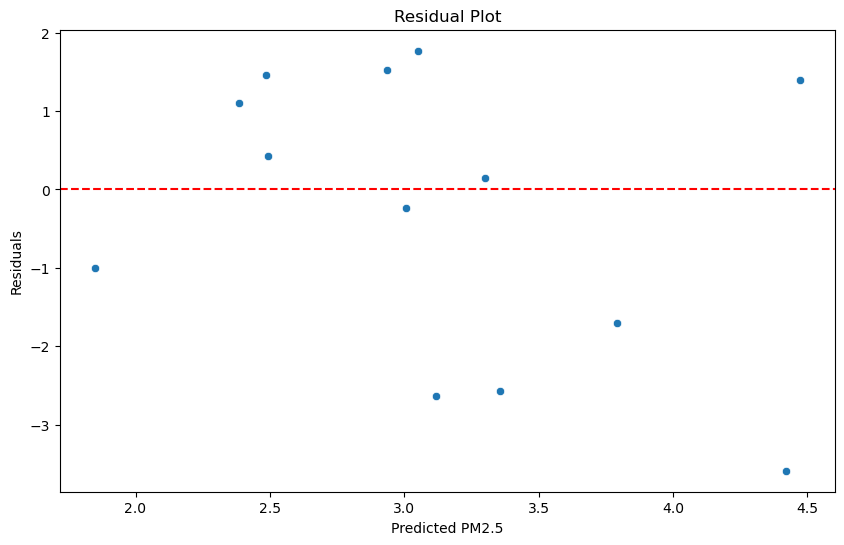

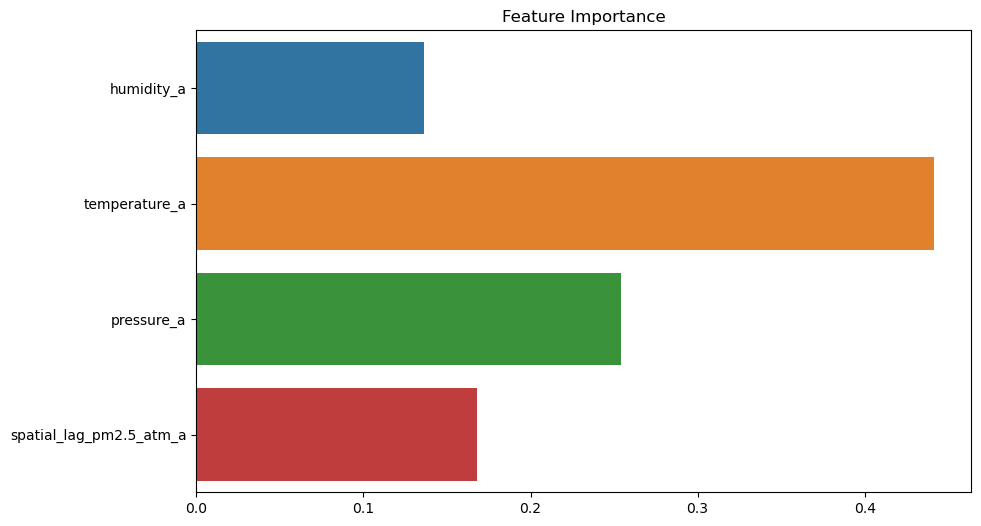

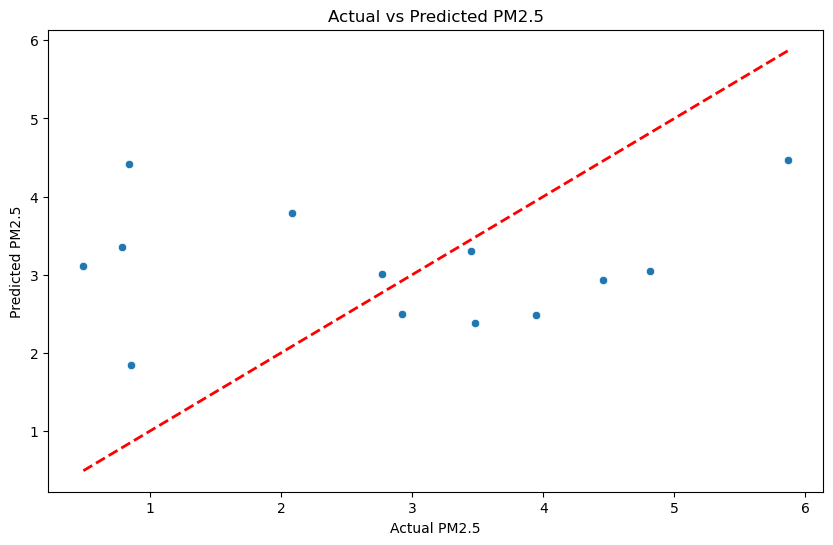

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model_visualizations(pipeline, X_test, y_test, y_pred):
    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted PM2.5')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    # Feature importance
    feature_importance = pipeline.named_steps['xgbreg'].feature_importances_
    features = X_test.columns
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=features)
    plt.title('Feature Importance')
    plt.show()

    # Actual vs Predicted plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual PM2.5')
    plt.ylabel('Predicted PM2.5')
    plt.title('Actual vs Predicted PM2.5')
    plt.show()

features = ['humidity_a', 'temperature_a', 'pressure_a', 'spatial_lag_pm2.5_atm_a']
target = 'pm2.5_atm_a'

X = data_march_30[features]
y = data_march_30[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('xgbreg', XGBRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

evaluate_model_visualizations(pipeline, X_test, y_test, y_pred)
